# Investments Assignment 3
**Group 1:** *Micah Yo Maheo, Majda Mechti, Xiaohe Xu*

## Problem 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import wrds
db = wrds.Connection(wrds_username='maheo')
#db.create_pgpass_file()

stocks = db.raw_sql("select date, vwretd from crsp.msi where date>='1960-01-01' and date<='2023-01-01'",
                    date_cols=['date'])
bonds = db.raw_sql("select caldt, b2ret from crsp.mcti where caldt>='1960-01-01' and caldt<='2023-01-01'", 
                   date_cols=['caldt'])


Loading library list...
Done


In [3]:
#a
dt = 12
rf = 0.01

pf6040 = 0.6*stocks['vwretd'] + 0.4*bonds['b2ret']
pf6040_m = pf6040.mean()*dt
pf6040_s = pf6040.std()*np.sqrt(dt)
pf6040_sr = (pf6040_m - rf)/(pf6040_s)
print('Annualized 60/40 portfolio mean:', round(pf6040_m,4),', std:', round(pf6040_s,4),
      'and Sharpe ratio:', round(pf6040_sr,4))

stocks_m = stocks['vwretd'].mean()*dt
stocks_s = stocks['vwretd'].std()*np.sqrt(dt)
bonds_m = bonds['b2ret'].mean()*dt
bonds_s = bonds['b2ret'].std()*np.sqrt(dt)
sb_corr = stocks['vwretd'].corr(bonds['b2ret'])

mu_rf = np.matrix([[stocks_m - rf],[bonds_m - rf]])
Sigma = np.matrix([[stocks_s**2,sb_corr*stocks_s*bonds_s],[sb_corr*stocks_s*bonds_s,bonds_s**2]])
pftan_sr = np.sqrt(mu_rf.getT()@Sigma.getI()@mu_rf)
wtan = (Sigma.getI()@mu_rf)/(np.ones(2)@Sigma.getI()@mu_rf)
pftan_m = wtan[0,0]*stocks_m + wtan[1,0]*bonds_m
pftan_s = np.sqrt(wtan[0,0]**2*stocks_s**2 + wtan[1,0]**2*bonds_s**2 
                + 2*wtan[0,0]*wtan[1,0]*sb_corr*stocks_s*bonds_s)
print('Annualized tangency portfolio mean:', round(pftan_m,4),', std:', round(pftan_s,4),
      'and Sharpe ratio:', round(pftan_sr[0,0],4), '(weight:', round(100*wtan[0,0],4),'% in stocks)')

Annualized 60/40 portfolio mean: 0.0847 , std: 0.0942 and Sharpe ratio: 0.7933
Annualized tangency portfolio mean: 0.0566 , std: 0.0286 and Sharpe ratio: 1.6274 (weight: 5.5045 % in stocks)


Annualized RP portfolio mean: 0.0617 , std: 0.0351 and Sharpe ratio: 1.472
Annualized RP Levered portfolio mean: 0.1487 , std: 0.0942 and Sharpe ratio: 1.472


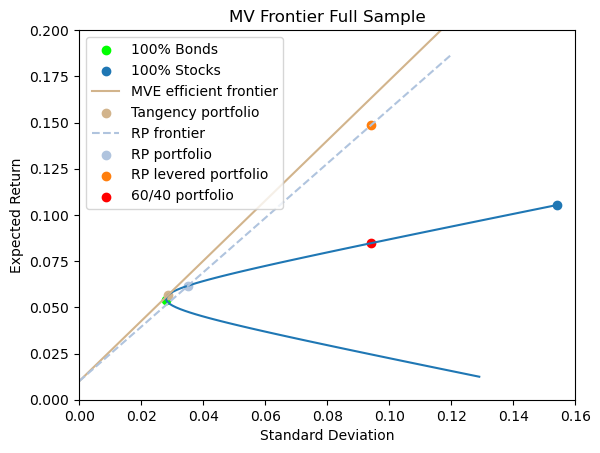

In [4]:
#b
wrp = (1/stocks_s)/(1/stocks_s + 1/bonds_s)
pfrp = wrp*stocks['vwretd'] + (1-wrp)*bonds['b2ret']
pfrp_m = pfrp.mean()*dt
pfrp_s = pfrp.std()*np.sqrt(dt)
pfrp_sr = (pfrp_m - rf)/(pfrp_s)
print('Annualized RP portfolio mean:', round(pfrp_m,4),', std:', round(pfrp_s,4),
      'and Sharpe ratio:', round(pfrp_sr,4))

pfrpL_s = pf6040_s
pfrpL_m = rf + pfrp_sr*pfrpL_s
pfrpL_sr = (pfrpL_m - rf)/(pfrpL_s)
wrpL = (pfrpL_m - bonds_m)/(stocks_m - bonds_m)
print('Annualized RP Levered portfolio mean:', round(pfrpL_m,4),', std:', round(pfrpL_s,4),
      'and Sharpe ratio:', round(pfrpL_sr,4))

x = np.linspace(0,0.12,100)
mve_frontier = rf + pftan_sr[0,0]*x
rp_frontier = rf + pfrp_sr*x
w = np.linspace(-0.8,1,100)
pfexr = w*stocks_m + (1-w)*bonds_m
pfstd = np.sqrt(w**2*stocks_s**2 + (1-w)**2*bonds_s**2 + 2*w*(1-w)*sb_corr*stocks_s*bonds_s)

plt.plot(pfstd,pfexr)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.scatter(bonds_s,bonds_m,label='100% Bonds', color='lime')
plt.scatter(stocks_s,stocks_m,label='100% Stocks')
plt.plot(x,mve_frontier,label='MVE efficient frontier', color='tan')
plt.scatter(pftan_s,pftan_m,label='Tangency portfolio', color='tan')
plt.plot(x,rp_frontier,label='RP frontier', linestyle='dashed', color='lightsteelblue')
plt.scatter(pfrp_s,pfrp_m,label='RP portfolio', color='lightsteelblue')
plt.scatter(pfrpL_s,pfrpL_m,label='RP levered portfolio')
plt.scatter(pf6040_s,pf6040_m,label='60/40 portfolio', color='red')
plt.xlim(0, 0.16)
plt.ylim(0, 0.20)
plt.legend()
plt.title('MV Frontier Full Sample')
plt.show()

In [5]:
#c

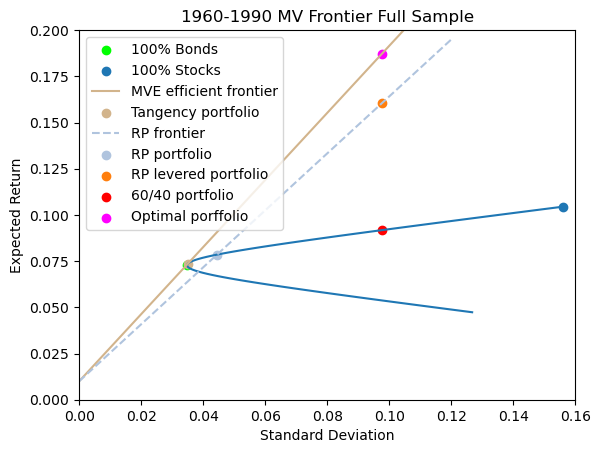

Annualized 1960-1990 60/40 portfolio mean: 0.0918 , std: 0.0977 and Sharpe ratio: 0.8372
Annualized 1960-1990 optimal portfolio mean: 0.1872 , std: 0.0977 and Sharpe ratio: 1.8145
Annualized 1960-1990 RP Levered portfolio mean: 0.1605 , std: 0.0977 and Sharpe ratio: 1.5407


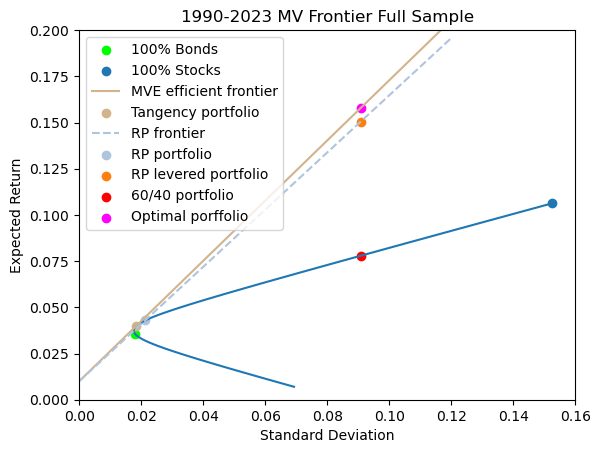

Annualized 1990-2023 60/40 portfolio mean: 0.0779 , std: 0.0908 and Sharpe ratio: 0.7479
Annualized 1990-2023 optimal portfolio mean: 0.1578 , std: 0.0908 and Sharpe ratio: 1.6281
Annualized 1990-2023 RP Levered portfolio mean: 0.1505 , std: 0.0908 and Sharpe ratio: 1.547


In [6]:
#d
dt = 12
rf = 0.01

#1960-1990
stocks90 = stocks.loc[(stocks['date'] <= '1990-12-31')]
bonds90 = bonds.loc[(bonds['caldt'] <= '1990-12-31')]
stocks_90m = stocks90['vwretd'].mean()*dt
stocks_90s = stocks90['vwretd'].std()*np.sqrt(dt)
bonds_90m = bonds90['b2ret'].mean()*dt
bonds_90s = bonds90['b2ret'].std()*np.sqrt(dt)
sb_corr90 = stocks90['vwretd'].corr(bonds90['b2ret'])

pf6040_90 = 0.6*stocks90['vwretd'] + 0.4*bonds90['b2ret']
pf6040_90m = pf6040_90.mean()*dt
pf6040_90s = pf6040_90.std()*np.sqrt(dt)
pf6040_90sr = (pf6040_90m - rf)/(pf6040_90s)

mu_rf = np.matrix([[stocks_90m - rf],[bonds_90m - rf]])
Sigma = np.matrix([[stocks_90s**2,sb_corr90*stocks_90s*bonds_90s],[sb_corr90*stocks_90s*bonds_90s,bonds_90s**2]])
pftan_90sr = np.sqrt(mu_rf.getT()@Sigma.getI()@mu_rf)
wtan90 = (Sigma.getI()@mu_rf)/(np.ones(2)@Sigma.getI()@mu_rf)
pftan_90m = wtan90[0,0]*stocks_90m + wtan90[1,0]*bonds_90m
pftan_90s = np.sqrt(wtan90[0,0]**2*stocks_90s**2 + wtan90[1,0]**2*bonds_90s**2 
                + 2*wtan90[0,0]*wtan90[1,0]*sb_corr90*stocks_90s*bonds_90s)

pfmve_90m = rf + pftan_90sr[0,0]*pf6040_90s
pfmve_90s = pf6040_90s
pfmve_90sr = (pfmve_90m - rf)/(pfmve_90s)

wrp90 = (1/stocks_90s)/(1/stocks_90s + 1/bonds_90s)
pfrp90 = wrp90*stocks90['vwretd'] + (1-wrp90)*bonds90['b2ret']
pfrp_90m = pfrp90.mean()*dt
pfrp_90s = pfrp90.std()*np.sqrt(dt)
pfrp_90sr = (pfrp_90m - rf)/(pfrp_90s)

pfrpL_90s = pf6040_90s
pfrpL_90m = rf + pfrp_90sr*pfrpL_90s
pfrpL_90sr = (pfrpL_90m - rf)/(pfrpL_90s)
wrpL90 = (pfrpL_90m - bonds_90m)/(stocks_90m - bonds_90m)

x = np.linspace(0,0.12,100)
mve_frontier90 = rf + pftan_90sr[0,0]*x
rp_frontier90 = rf + pfrp_90sr*x
w = np.linspace(-0.8,1,100)
pfexr = w*stocks_90m + (1-w)*bonds_90m
pfstd = np.sqrt(w**2*stocks_90s**2 + (1-w)**2*bonds_90s**2 + 2*w*(1-w)*sb_corr90*stocks_90s*bonds_90s)

plt.plot(pfstd,pfexr)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.scatter(bonds_90s,bonds_90m,label='100% Bonds', color='lime')
plt.scatter(stocks_90s,stocks_90m,label='100% Stocks')
plt.plot(x,mve_frontier90,label='MVE efficient frontier', color='tan')
plt.scatter(pftan_90s,pftan_90m,label='Tangency portfolio', color='tan')
plt.plot(x,rp_frontier90,label='RP frontier', linestyle='dashed', color='lightsteelblue')
plt.scatter(pfrp_90s,pfrp_90m,label='RP portfolio', color='lightsteelblue')
plt.scatter(pfrpL_90s,pfrpL_90m,label='RP levered portfolio')
plt.scatter(pf6040_90s,pf6040_90m,label='60/40 portfolio', color='red')
plt.scatter(pfmve_90s,pfmve_90m,label='Optimal porffolio', color='magenta')
plt.xlim(0, 0.16)
plt.ylim(0, 0.20)
plt.legend()
plt.title('1960-1990 MV Frontier Full Sample')
plt.show()
print('Annualized 1960-1990 60/40 portfolio mean:', round(pf6040_90m,4),', std:', round(pf6040_90s,4),
      'and Sharpe ratio:', round(pf6040_90sr,4))
print('Annualized 1960-1990 optimal portfolio mean:', round(pfmve_90m,4),', std:', round(pfmve_90s,4),
      'and Sharpe ratio:', round(pfmve_90sr,4))
print('Annualized 1960-1990 RP Levered portfolio mean:', round(pfrpL_90m,4),', std:', round(pfrpL_90s,4),
      'and Sharpe ratio:', round(pfrpL_90sr,4))
#-----------------------------------------------------
#-----------------------------------------------------

#1990-2023
stocks23 = stocks.loc[(stocks['date'] > '1990-12-31')]
bonds23 = bonds.loc[(bonds['caldt'] > '1990-12-31')]
stocks_23m = stocks23['vwretd'].mean()*dt
stocks_23s = stocks23['vwretd'].std()*np.sqrt(dt)
bonds_23m = bonds23['b2ret'].mean()*dt
bonds_23s = bonds23['b2ret'].std()*np.sqrt(dt)
sb_corr23 = stocks23['vwretd'].corr(bonds23['b2ret'])

pf6040_23 = 0.6*stocks23['vwretd'] + 0.4*bonds23['b2ret']
pf6040_23m = pf6040_23.mean()*dt
pf6040_23s = pf6040_23.std()*np.sqrt(dt)
pf6040_23sr = (pf6040_23m - rf)/(pf6040_23s)

mu_rf = np.matrix([[stocks_23m - rf],[bonds_23m - rf]])
Sigma = np.matrix([[stocks_23s**2,sb_corr23*stocks_23s*bonds_23s],[sb_corr23*stocks_23s*bonds_23s,bonds_23s**2]])
pftan_23sr = np.sqrt(mu_rf.getT()@Sigma.getI()@mu_rf)
wtan23 = (Sigma.getI()@mu_rf)/(np.ones(2)@Sigma.getI()@mu_rf)
pftan_23m = wtan23[0,0]*stocks_23m + wtan23[1,0]*bonds_23m
pftan_23s = np.sqrt(wtan23[0,0]**2*stocks_23s**2 + wtan23[1,0]**2*bonds_23s**2 
                + 2*wtan23[0,0]*wtan23[1,0]*sb_corr23*stocks_23s*bonds_23s)

pfmve_23m = rf + pftan_23sr[0,0]*pf6040_23s
pfmve_23s = pf6040_23s
pfmve_23sr = (pfmve_23m - rf)/(pfmve_23s)

wrp23 = (1/stocks_23s)/(1/stocks_23s + 1/bonds_23s)
pfrp23 = wrp23*stocks23['vwretd'] + (1-wrp23)*bonds23['b2ret']
pfrp_23m = pfrp23.mean()*dt
pfrp_23s = pfrp23.std()*np.sqrt(dt)
pfrp_23sr = (pfrp_23m - rf)/(pfrp_23s)

pfrpL_23s = pf6040_23s
pfrpL_23m = rf + pfrp_23sr*pfrpL_23s
pfrpL_23sr = (pfrpL_23m - rf)/(pfrpL_23s)
wrpL23 = (pfrpL_23m - bonds_23m)/(stocks_23m - bonds_23m)

x = np.linspace(0,0.12,100)
mve_frontier23 = rf + pftan_23sr[0,0]*x
rp_frontier23 = rf + pfrp_23sr*x
w = np.linspace(-0.4,1,100)
pfexr = w*stocks_23m + (1-w)*bonds_23m
pfstd = np.sqrt(w**2*stocks_23s**2 + (1-w)**2*bonds_23s**2 + 2*w*(1-w)*sb_corr23*stocks_23s*bonds_23s)

plt.plot(pfstd,pfexr)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.scatter(bonds_23s,bonds_23m,label='100% Bonds', color='lime')
plt.scatter(stocks_23s,stocks_23m,label='100% Stocks')
plt.plot(x,mve_frontier23,label='MVE efficient frontier', color='tan')
plt.scatter(pftan_23s,pftan_23m,label='Tangency portfolio', color='tan')
plt.plot(x,rp_frontier23,label='RP frontier', linestyle='dashed', color='lightsteelblue')
plt.scatter(pfrp_23s,pfrp_23m,label='RP portfolio', color='lightsteelblue')
plt.scatter(pfrpL_23s,pfrpL_23m,label='RP levered portfolio')
plt.scatter(pf6040_23s,pf6040_23m,label='60/40 portfolio', color='red')
plt.scatter(pfmve_23s,pfmve_23m,label='Optimal porffolio', color='magenta')
plt.xlim(0, 0.16)
plt.ylim(0, 0.20)
plt.legend()
plt.title('1990-2023 MV Frontier Full Sample')
plt.show()
print('Annualized 1990-2023 60/40 portfolio mean:', round(pf6040_23m,4),', std:', round(pf6040_23s,4),
      'and Sharpe ratio:', round(pf6040_23sr,4))
print('Annualized 1990-2023 optimal portfolio mean:', round(pfmve_23m,4),', std:', round(pfmve_23s,4),
      'and Sharpe ratio:', round(pfmve_23sr,4))
print('Annualized 1990-2023 RP Levered portfolio mean:', round(pfrpL_23m,4),', std:', round(pfrpL_23s,4),
      'and Sharpe ratio:', round(pfrpL_23sr,4))
